using CABLAB
include("Optimize_NPP.jl")
registerDATFunction(optimize_npp,(TimeAxis,VariableAxis));
registerDATFunction(predict_npp,((TimeAxis,VariableAxis),()),(TimeAxis,)); 

Here, we want to show how the cube and the DAT might be used for model parameter estimation. It also shows how the mapCube function can be applied on multiple input data cubes. 

In the file *Optimize_NPP.jl* we defined a function called **predict_npp** which predicts the ecosystem's net productivity (**NPP**) based on air temperature, fpar and radiation using a very simple model. One of the model parameters is the optimal growing temperature **Topt** at which the productivity reaches its maximum. We assume that this parameter varies across ecosystems, because they adapt to their normal environmental conditions. 

In [16]:
c             = Cube("/Net/Groups/BGI/scratch/DataCube/v0.2.0/low-res/")

CABLAB data cube at /Net/Groups/BGI/scratch/DataCube/v0.2.0/low-res/
Spatial resolution:  1440x720 at 0.25 degrees.
Temporal resolution: 2001-01-01T00:00:00 to 2012-01-01T00:00:00 at 8daily time steps
Variables:           Rg aerosol_optical_thickness_1610 aerosol_optical_thickness_550 aerosol_optical_thickness_555 aerosol_optical_thickness_659 aerosol_optical_thickness_865 air_temperature_2m bare_soil_evaporation black_sky_albedo burnt_area c_emissions country_mask evaporation evaporative_stress fpar_fluxcom fractional_snow_cover gross_primary_productivity interception_loss land_surface_temperature latent_energy net_ecosystem_exchange open_water_evaporation ozone potential_evaporation precipitation root_moisture sensible_heat snow_sublimation snow_water_equivalent soil_moisture surface_moisture terrestrial_ecosystem_respiration transpiration water_mask water_vapour white_sky_albedo 


In [17]:
vars          = ["air_temperature_2m","fpar_fluxcom","Rg"];
cdata         = getCubeData(c,variable=vars,longitude=(-10,35),latitude=(35,65));

In [18]:
cdata_filled  = mapCube(gapFillMSC,cdata);

In the first experiment we assume that the model parameter **Topt** equals the mean temperature of each grid cell.

In [19]:
tair=getCubeData(c,variable="air_temperature_2m",longitude=(-10,35),latitude=(35,65))
mtair=reduceCube(mean, tair, TimeAxis);

We pass the mean air temperature mtair as a second cube argument to the **mapCube** function.

In [20]:
predict_nppmean=mapCube(predict_npp,(cdata_filled,mtair));

Now, we can plot time series and maps of the predicted NEE. 

In [21]:
plotTS(predict_nppmean)

Interact.Options{:Dropdown,Any}(Signal{Any}(0, nactions=0),"Group",0,"None",Interact.OptionDict(Any["None","Lon","Lat"],Dict{Any,Any}(Pair{Any,Any}("None",0),Pair{Any,Any}("Lon",2),Pair{Any,Any}("Lat",3))),Any[],Any[])

Interact.Slider{Float64}(Signal{Float64}(12.25, nactions=0),"Lon",12.25,-10.0:0.25:34.75,".3f",true)

Interact.Slider{Float64}(Signal{Float64}(50.0, nactions=0),"Lat",50.0,35.25:0.25:65.0,".3f",true)

Now we want to estimate the optimal growing temperature differently. Instead of just calculating the mean temperature we choose **Topt** so that the time mean of **NEE** is maximised for each gride cell. We do this by wrapping an optimization method from Julia's Optim package. 

In [25]:
topt=mapCube(optimize_npp,cdata_filled)

In-Memory data cube with the following dimensions
Lon                 Axis with 180 Elements from -10.0 to 34.75
Lat                 Axis with 120 Elements from 65.0 to 35.25


And we get a map of the optimal growing temperature

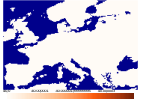

In [26]:
plotMAP(topt)

And the resulting NEE

In [ ]:
predict_nppopt=mapCube(predict_npp,(cdata_filled,topt));

In [ ]:
plotMAP(predict_nppopt)

In order to calculate the global map of Topt we add a few processors and repate the saem steps on the global cube

In [ ]:
#using ClusterBGC
#addprocs_lsf(20,queue="BTM")
addprocs(10)
@everywhere include("Optimize_NPP.jl")

In [ ]:
CABLAB.DAT.init_DATworkers()

In [ ]:
cdata         = getCubeData(c,variable=vars);
@time cdata_filled  = mapCube(gapFillMSC,cdata);
@time topt=mapCube(optimize_npp,cdata_filled,max_cache=1e7);

We can compare the optimum growing temperature (first plot) with the mean air temperature (second plot). In very cold regions you see that **Topt** is higher, probably because of the low temperatures occur when fpar and radiation are also very low and carbon uptake is not possible. 

In [ ]:
plotMAP(topt,dmin=0.f0,dmax=30.f0)

In [ ]:
tair=getCubeData(c,variable="air_temperature_2m")
@time mtair=reduceCube(mean, tair, TimeAxis, skipnull=true);
plotMAP(mtair,dmin=0.f0,dmax=30.f0)

In [ ]:
rmprocs(workers())